# Vehicle Detection  

## Import libraries

In [220]:
# Include statements so Python modules are always reloaded.
# Speeds debugging and iteration
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
# Import modules for use within Jupyter workspace

import glob
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

In [222]:
#from helperfunctions import *
import helperfunctions as hf
import lesson_functions as lf

## Get paths to images and prepare to read them in

Number of car images =  8792
Number of not car images =  8968
Random car path =  /Users/blakejacquot/Desktop/temp/training_images/vehicles/GTI_Far/image0036.png
Random not car path =  /Users/blakejacquot/Desktop/temp/training_images/non-vehicles/Extras/extra2700.png


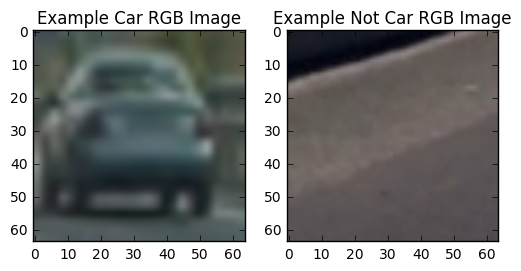

Mean, min, max of an image 0.310551 0.0705882 0.615686


In [223]:
car_path = '/Users/blakejacquot/Desktop/temp/training_images/vehicles'
notcar_path = '/Users/blakejacquot/Desktop/temp/training_images/non-vehicles'

cars, notcars = hf.get_car_notcar_paths(car_path, notcar_path, verbose = True)

## Explore histogram of gradients (HOG) features

In [224]:
# Define HOG parameters
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
color_conv = 'RGB2YCrCb'

### Test HOG with random image

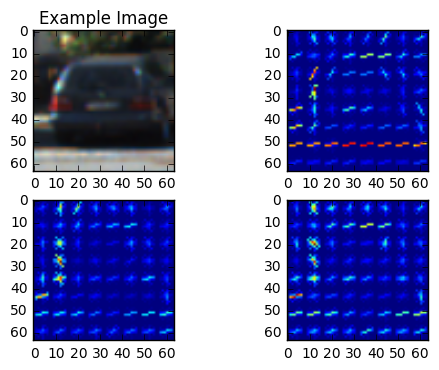

HOG features native <class 'numpy.ndarray'> (1764,)


In [225]:
# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
rand_car = cars[random.randint(1, len(cars))]

# Read in the image
img_car = mpimg.imread(rand_car)

ctrans_tosearch = lf.convert_color(img_car, conv=color_conv)

ch1 = ctrans_tosearch[:,:,0]
ch2 = ctrans_tosearch[:,:,1]
ch3 = ctrans_tosearch[:,:,2]

# Compute individual channel HOG features for the entire image
hog1feat, hog1img = lf.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog2feat, hog2img = lf.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog3feat, hog3img = lf.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot images
fig = plt.figure()
plt.subplot(221)
plt.imshow(img_car)
plt.title('Example Image')
plt.subplot(222)
plt.imshow(hog1img)
plt.subplot(223)
plt.imshow(hog2img)
plt.subplot(224)
plt.imshow(hog3img)
plt.show()

print('HOG features native', type(hog1feat), np.shape(hog1feat))
#HOG_features_flattened = features_car.flatten()
#print('HOG features flattened', HOG_features_flattened)
#print('HOG features stats', max(HOG_features_flattened), min(HOG_features_flattened), len(HOG_features_flattened), np.median(HOG_features_flattened))


## Define color histogram and spatial features parameters

In [226]:
# Histogram and spatial features parameters
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
channel = 'ALL'

# HOG parameter
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
hog_channel = 'ALL'

imgs = [rand_car]

In [227]:
features = lf.extract_features(imgs, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print('Shape of feature vector', np.shape(features))

Shape of feature vector (1, 8460)


In [228]:
car_features = lf.extract_features(cars, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

notcar_features = lf.extract_features(notcars, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print('car_features shape ', np.shape(car_features))
print('notcar_features shape ', np.shape(notcar_features))

car_features shape  (8792, 8460)
notcar_features shape  (8968, 8460)


In [229]:
svc, X_scaler = hf.train_model(car_features, notcar_features)

X shape (17760, 8460)
scaled_X shape (17760, 8460)
y (17760,)
X_train  (14208, 8460)
Feature vector length: 8460
21.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
0.00094 Seconds to predict 10 labels with SVC
<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.preprocessing.data.StandardScaler'>


In [230]:
print(type(svc))
print(type(X_scaler))

<class 'sklearn.svm.classes.LinearSVC'>
<class 'sklearn.preprocessing.data.StandardScaler'>


In [231]:
# Save data to file so we don't have to redo training

import pickle

data = {'svc': svc,
         'X_scaler': X_scaler
        }

output = open('data.pkl', 'wb')
pickle.dump(data, output)
output.close()


In [232]:
import pickle


# Read in data

pkl_file = open('data.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

svc = data['svc']
X_scaler = data['X_scaler']


## Work with jpg files supplied by Udacity

In [233]:
# Get paths to test images
testimg_path = os.path.join('.', 'test_images/')
testimgs = []
testimgs= glob.glob(os.path.join(testimg_path, '*.jpg'))
print(testimgs)

['./test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


## Explore sliding window search

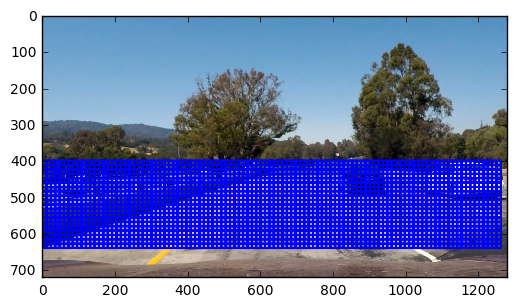

In [234]:
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32) # (32,32), (16,16)
hist_bins=32

# HOG parameter
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
hog_channel = 'ALL'

y_start = 400
y_stop = 656

spatial_feat = True
hist_feat = True
hog_feat = True

image = mpimg.imread(testimgs[0])

out_img, curr_windows, all_windows = lf.find_cars(image, y_start, y_stop, scale, svc,
                                         X_scaler, orient, pix_per_cell,
                                         cell_per_block, spatial_size, hist_bins, verbose_return = True)

window_img = lf.draw_boxes(image, all_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

## Try vehicle detection on jpg images

In [235]:
# Reiterate variables for good measure

cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32) # (32,32), (16,16)
hist_bins=32
hist_range=(0, 256)
channel = 'ALL'

# HOG parameter
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
hog_channel = 'ALL'

x_start = None
x_stop = None
y_start = 400
y_stop = 656

spatial_feat = True
hist_feat = True
hog_feat = True

scale = 1.5

Hot windows [((832, 400), (960, 528))]


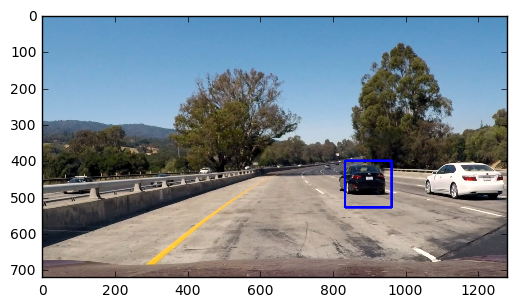

Hot windows [((848, 400), (880, 432)), ((1104, 400), (1136, 432)), ((864, 416), (896, 448)), ((896, 416), (928, 448)), ((832, 432), (864, 464)), ((912, 432), (944, 464)), ((1152, 432), (1184, 464))]


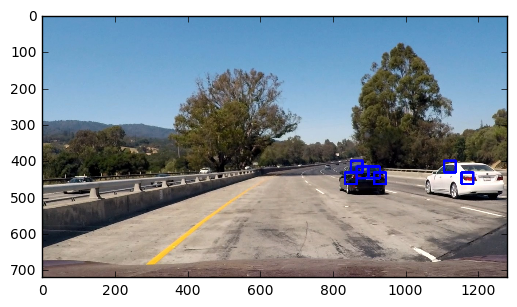

In [236]:
image = mpimg.imread(testimgs[0])
draw_image = np.copy(image)

image = image.astype(np.float32)/255

# Window 1
xy_window= (128, 128) #(128, 128)
xy_overlap=(0.5, 0.5) #(0.5, 0.5)
windows = lf.slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                    xy_window=xy_window, xy_overlap=xy_overlap)
hot_windows = lf.search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
print('Hot windows', hot_windows)
window_img = lf.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()


# Window 2
xy_window= (32, 32) #(128, 128)
xy_overlap=(0.5, 0.5) #(0.5, 0.5)
windows = lf.slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                    xy_window=xy_window, xy_overlap=xy_overlap)
hot_windows = lf.search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
print('Hot windows', hot_windows)
window_img = lf.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()


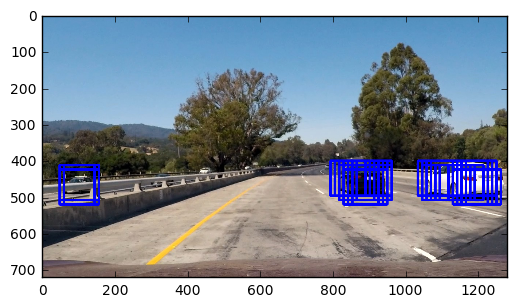

In [237]:
# Try HOG subsampling
scale = 1.5
image = mpimg.imread(testimgs[0])
# Expects to receive jpeg file on scale of 0 to 1
out_img, window_list = lf.find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
plt.show()

## Add heatmap

./test_images/test1.jpg
hot_windows [((832, 408), (896, 472)), ((832, 416), (896, 480)), ((840, 424), (904, 488)), ((840, 432), (904, 496)), ((848, 408), (912, 472)), ((856, 408), (920, 472)), ((864, 408), (928, 472)), ((864, 432), (928, 496)), ((872, 400), (936, 464)), ((872, 408), (936, 472)), ((880, 408), (944, 472)), ((880, 432), (944, 496)), ((1208, 448), (1272, 512)), ((32, 400), (160, 528)), ((144, 432), (272, 560)), ((320, 416), (448, 544)), ((800, 400), (928, 528)), ((816, 400), (944, 528)), ((816, 416), (944, 544)), ((832, 400), (960, 528)), ((1008, 400), (1136, 528)), ((1040, 400), (1168, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1104, 400), (1232, 528)), ((1120, 400), (1248, 528)), ((1120, 416), (1248, 544)), ((1136, 400), (1264, 528)), ((1136, 416), (1264, 544))]


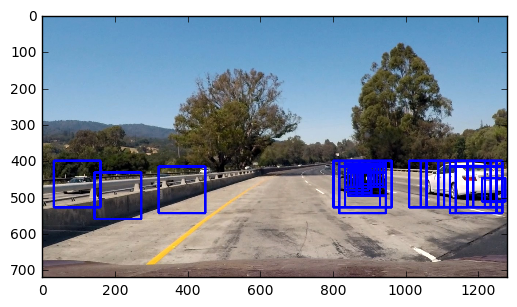

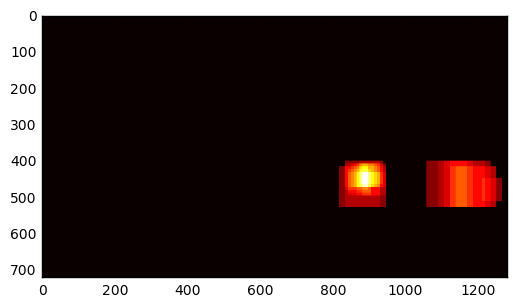

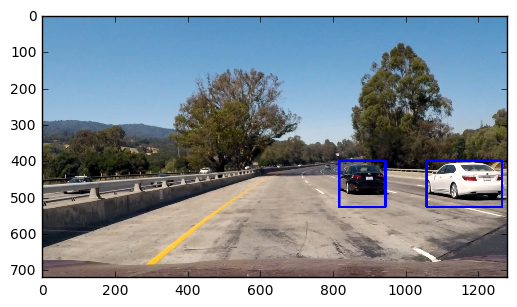

In [238]:
print(testimgs[0])
image = mpimg.imread(testimgs[0])
threshold = 2

hf.initiate_globals()
draw_img, hot_windows, currheat, labels = hf.process_frame(image, threshold, verbose_return = True)

print('hot_windows', hot_windows)

# All windows searched
#window_img = lf.draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
#plt.imshow(window_img)
#plt.show()

# Windows where car was detected
window_img = lf.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

# Heat map
plt.imshow(currheat, cmap='hot')
plt.show()

# Final detection windows
plt.imshow(draw_img)
plt.show()

## Process all jpegs

./test_images/test1.jpg
1
./output_images/test1.png


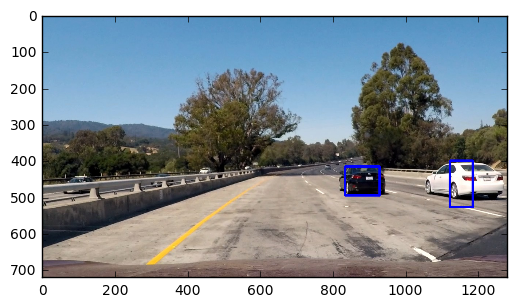

./test_images/test2.jpg
2
./output_images/test2.png


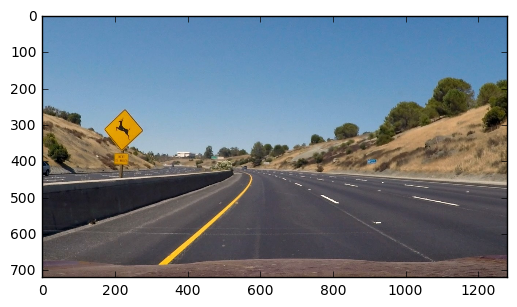

./test_images/test3.jpg
3
./output_images/test3.png


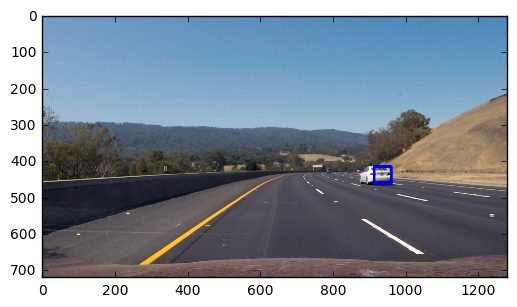

./test_images/test4.jpg
4
./output_images/test4.png


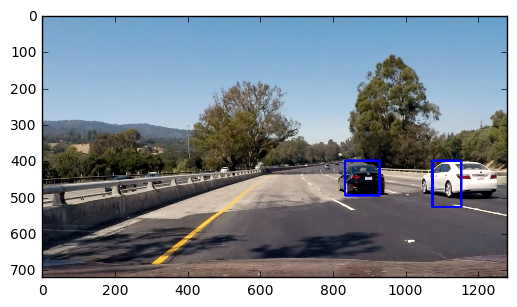

./test_images/test5.jpg
5
./output_images/test5.png


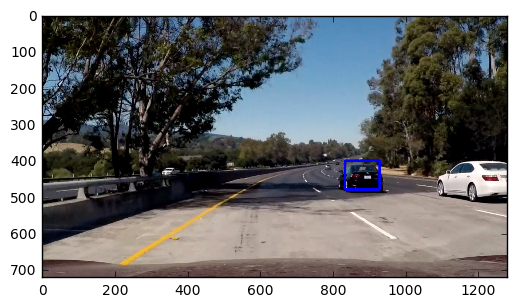

./test_images/test6.jpg
6
./output_images/test6.png


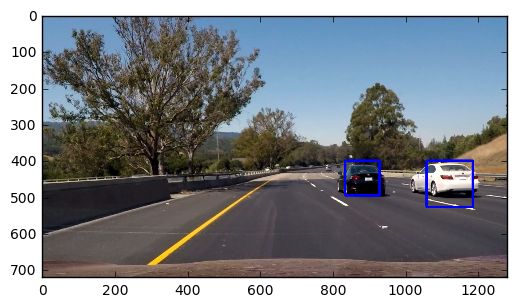

In [245]:
for img in testimgs:
    print(img)
    image = mpimg.imread(img)
    # Process images
    hf.initiate_globals()
    threshold = 2
    draw_img = hf.process_frame(image, threshold)
    
    # Display and save images
    imgnum = img[-5:-4]
    print(imgnum)
    savename = 'test' + str(imgnum) + '.png'
    savepath = os.path.join('.', 'output_images', savename)
    print(savepath)
    mpimg.imsave(savepath, draw_img)    
    plt.imshow(draw_img)
    plt.show()

## Test on video

In [246]:
video_path = os.path.join('.', 'test_video.mp4')
output_path = os.path.join('.', 'test_video_out.mp4')
hf.process_video(video_path, output_path)

[MoviePy] >>>> Building video ./test_video_out.mp4
[MoviePy] Writing video ./test_video_out.mp4


 97%|█████████▋| 38/39 [00:38<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out.mp4 



In [257]:
video_path = os.path.join('.', 'bcjtest.mp4')
output_path = os.path.join('.', 'bcjtest_out.mp4')
hf.process_video(video_path, output_path)

[MoviePy] >>>> Building video ./bcjtest_out.mp4
[MoviePy] Writing video ./bcjtest_out.mp4




  0%|          | 0/35 [00:00<?, ?it/s]

  3%|▎         | 1/35 [00:00<00:33,  1.01it/s]

  6%|▌         | 2/35 [00:01<00:32,  1.01it/s]

  9%|▊         | 3/35 [00:02<00:31,  1.01it/s]

 11%|█▏        | 4/35 [00:03<00:30,  1.01it/s]

 14%|█▍        | 5/35 [00:04<00:29,  1.02it/s]

 17%|█▋        | 6/35 [00:05<00:28,  1.03it/s]

 20%|██        | 7/35 [00:06<00:27,  1.02it/s]

 23%|██▎       | 8/35 [00:07<00:27,  1.00s/it]

 26%|██▌       | 9/35 [00:09<00:26,  1.03s/it]

 29%|██▊       | 10/35 [00:10<00:26,  1.05s/it]

 31%|███▏      | 11/35 [00:11<00:26,  1.11s/it]

 34%|███▍      | 12/35 [00:12<00:27,  1.22s/it]

 37%|███▋      | 13/35 [00:13<00:25,  1.16s/it]

 40%|████      | 14/35 [00:14<00:22,  1.10s/it]

 43%|████▎     | 15/35 [00:15<00:21,  1.05s/it]

 46%|████▌     | 16/35 [00:16<00:19,  1.03s/it]

 49%|████▊     | 17/35 [00:17<00:18,  1.02s/it]

 51%|█████▏    | 18/35 [00:18<00:17,  1.03s/it]

 54%|█████▍    | 19/35 [00:19<00:16,  1.02s/it]

 57%|█████▋    | 20/35 [00:21<00:16,

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./bcjtest_out.mp4 



In [258]:
video_path = os.path.join('.', 'project_video.mp4')
output_path = os.path.join('.', 'project_video_out.mp4')
hf.process_video(video_path, output_path)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<21:03,  1.00s/it]

  0%|          | 2/1261 [00:01<20:58,  1.00it/s]

  0%|          | 3/1261 [00:02<20:52,  1.00it/s]

  0%|          | 4/1261 [00:03<20:30,  1.02it/s]

  0%|          | 5/1261 [00:04<20:21,  1.03it/s]

  0%|          | 6/1261 [00:05<20:29,  1.02it/s]

  1%|          | 7/1261 [00:06<21:17,  1.02s/it]

  1%|          | 8/1261 [00:08<21:55,  1.05s/it]

  1%|          | 9/1261 [00:09<22:25,  1.07s/it]

  1%|          | 10/1261 [00:10<21:40,  1.04s/it]

  1%|          | 11/1261 [00:11<20:56,  1.01s/it]

  1%|          | 12/1261 [00:12<20:22,  1.02it/s]

  1%|          | 13/1261 [00:12<20:01,  1.04it/s]

  1%|          | 14/1261 [00:13<20:17,  1.02it/s]

  1%|          | 15/1261 [00:14<19:55,  1.04it/s]

  1%|▏         | 16/1261 [00:15<20:40,  1.00it/s]

  1%|▏         | 17/1261 [00:17<21:27,  1.03s/it]

  1%|▏         | 18/1261 [00:18<22:12,  1.07s/it]

  2%|▏         | 19/1261 [00:19<22:40,  1.10s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

